In [2]:
import os
import tarfile
import cv2
import numpy as np
import matplotlib as pyplot

## Download and extract dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
os.listdir('freiburg_groceries_dataset.tar.gz')

['Getting started.pdf', 'Colab Notebooks', 'freiburg_groceries_dataset.tar.gz']

In [5]:
# Extract the dataset
location = "/content/drive/MyDrive/"
filename = 'freiburg_groceries_dataset.tar.gz'
target_directory = 'freiburg_groceries_dataset'

if not os.path.exists(location + target_directory):
    with tarfile.open(location + filename) as tar:
        tar.extractall(location + target_directory)

## Load images and create a string tag for all of them. (using tqdm)
## On-hot the string labels.

In [6]:
import os
import numpy as np
import cv2
from tqdm import tqdm
from sklearn.preprocessing import LabelBinarizer

# Load images and labels
def load_images_and_labels(data_dir):
    images = []
    labels = []
    classes = sorted(os.listdir(data_dir))
    for label in tqdm(classes):
        class_dir = os.path.join(data_dir, label)
        if os.path.isdir(class_dir):
            for image_name in os.listdir(class_dir):
                image_path = os.path.join(class_dir, image_name)
                image = cv2.imread(image_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, (128, 128))
                images.append(image)
                labels.append(label)
    return np.array(images), np.array(labels)

data_dir =  location + 'freiburg_groceries_dataset/images'
images, labels = load_images_and_labels(data_dir)

# One-hot encode labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

100%|██████████| 25/25 [01:34<00:00,  3.79s/it]


## Add 500 images to the dataset using data augmentation ( image generation).
## Use at least 3 desired arguments for the image data generator. (zoom, rotation, ... )
## Concatenate generated data.

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Generate augmented images
augmented_images, augmented_labels = [], []

for i in tqdm(range(500)):
    index = np.random.randint(0, len(images))
    image = images[index]
    label = labels[index]
    image = np.expand_dims(image, axis=0)
    augmented_image = datagen.flow(image, batch_size=1)[0]
    augmented_images.append(augmented_image[0])
    augmented_labels.append(label)

augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

# Concatenate original and augmented data
images = np.concatenate((images, augmented_images), axis=0)
labels = np.concatenate((labels, augmented_labels), axis=0)


100%|██████████| 500/500 [00:02<00:00, 186.01it/s]


## Use VGG16 as a pre-trained model. (Freeze the weights of VGG16)
## Design a suitable CNN network

In [8]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

# Load VGG16 model
VGG16 = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
VGG16.trainable = False  # Freeze the base model

# Design a suitable CNN network
model = Sequential([
    VGG16,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(lb.classes_), activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

58889256/58889256 [==============================] - 1s 0us/step


## Use the trained model to predict one sample image.

In [10]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

# Train the model
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val), batch_size=32)

Epoch 1/5
137/137 [==============================] - 1247s 9s/step - loss: 18.0368 - accuracy: 0.0799 - val_loss: 3.9695 - val_accuracy: 0.1706
Epoch 2/5
137/137 [==============================] - 1251s 9s/step - loss: 6.9990 - accuracy: 0.1040 - val_loss: 3.0521 - val_accuracy: 0.1734
Epoch 3/5
137/137 [==============================] - 1240s 9s/step - loss: 4.0716 - accuracy: 0.1171 - val_loss: 2.9701 - val_accuracy: 0.1541
Epoch 4/5
137/137 [==============================] - 1232s 9s/step - loss: 3.3764 - accuracy: 0.1244 - val_loss: 2.9751 - val_accuracy: 0.1679
Epoch 5/5
137/137 [==============================] - 1224s 9s/step - loss: 3.1259 - accuracy: 0.1409 - val_loss: 2.9510 - val_accuracy: 0.1725


## Use sample from dataset

1/1 [==============================] - 1s 1s/step


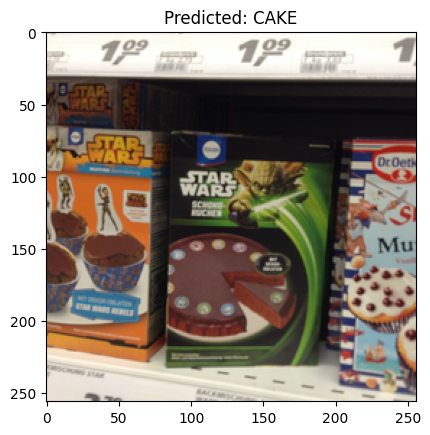

In [22]:
import matplotlib.pyplot as plt

# Load a sample image
sample_image_path = os.path.join(data_dir, 'CAKE', 'CAKE0000.png')
sample_image = cv2.imread(sample_image_path)
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
sample_image = cv2.resize(sample_image, (128, 128))
sample_image = np.expand_dims(sample_image, axis=0)

# Predict
predictions = model.predict(sample_image)
predicted_label = lb.inverse_transform(predictions)[0]

# Display the image and prediction
plt.imshow(cv2.cvtColor(cv2.imread(sample_image_path), cv2.COLOR_BGR2RGB))
plt.title(f'Predicted: {predicted_label}')
plt.show()

## Use sample from internet with Wrong Predict

1/1 [==============================] - 0s 411ms/step


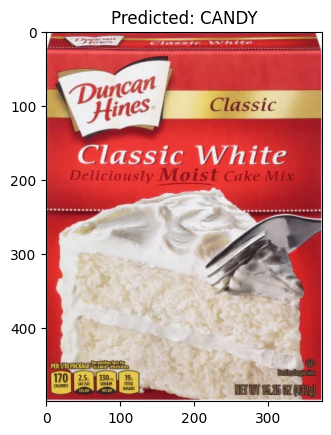

In [23]:
import matplotlib.pyplot as plt

# Load a sample image
sample_image_path = os.path.join(location, 'CAKE01.jpg')
sample_image = cv2.imread(sample_image_path)
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
sample_image = cv2.resize(sample_image, (128, 128))
sample_image = np.expand_dims(sample_image, axis=0)

# Predict
predictions = model.predict(sample_image)
predicted_label = lb.inverse_transform(predictions)[0]

# Display the image and prediction
plt.imshow(cv2.cvtColor(cv2.imread(sample_image_path), cv2.COLOR_BGR2RGB))
plt.title(f'Predicted: {predicted_label}')
plt.show()

## Use sample from internet with Right Predict

1/1 [==============================] - 0s 344ms/step


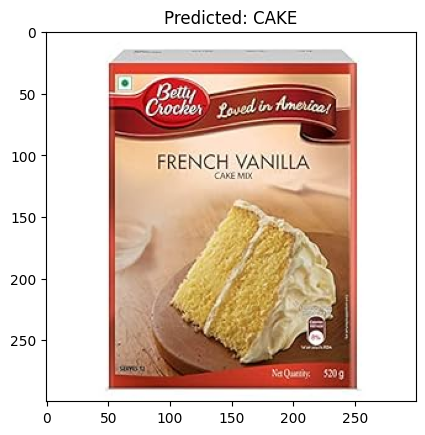

In [24]:
import matplotlib.pyplot as plt

# Load a sample image
sample_image_path = os.path.join(location, 'CAKE02.jpg')
sample_image = cv2.imread(sample_image_path)
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
sample_image = cv2.resize(sample_image, (128, 128))
sample_image = np.expand_dims(sample_image, axis=0)

# Predict
predictions = model.predict(sample_image)
predicted_label = lb.inverse_transform(predictions)[0]

# Display the image and prediction
plt.imshow(cv2.cvtColor(cv2.imread(sample_image_path), cv2.COLOR_BGR2RGB))
plt.title(f'Predicted: {predicted_label}')
plt.show()

## Save the model use that in another script. and predict one sample image using that.

In [27]:
# Save the model
model.save(location + 'grocery_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [30]:
# Checking that the model is saved
os.listdir(location)

['Colab Notebooks',
 'freiburg_groceries_dataset.tar.gz',
 'freiburg_groceries_dataset',
 'CAKE01.jpg',
 'CAKE02.jpg',
 'grocery_model.h5']

In [31]:
# Load the model in another script
from tensorflow.keras.models import load_model

# Load the model
loaded_model = load_model(location + 'grocery_model.h5')

# Predict on a sample image using the loaded model
predictions = loaded_model.predict(sample_image)
predicted_label = lb.inverse_transform(predictions)[0]

print(f'Predicted label: {predicted_label}')

1/1 [==============================] - 0s 389ms/step
Predicted label: CAKE


## Use sample from internet with Right Predict

1/1 [==============================] - 1s 500ms/step


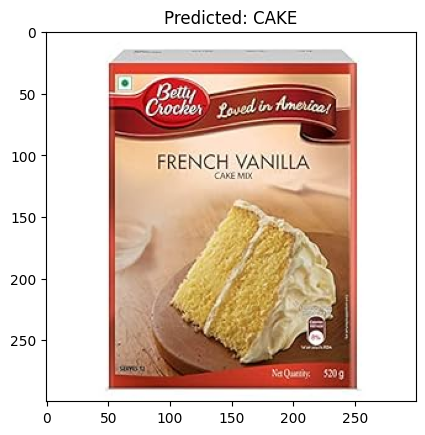

In [32]:
import matplotlib.pyplot as plt

# Load a sample image
sample_image_path = os.path.join(location, 'CAKE02.jpg')
sample_image = cv2.imread(sample_image_path)
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
sample_image = cv2.resize(sample_image, (128, 128))
sample_image = np.expand_dims(sample_image, axis=0)

# Predict
predictions = loaded_model.predict(sample_image)
predicted_label = lb.inverse_transform(predictions)[0]

# Display the image and prediction
plt.imshow(cv2.cvtColor(cv2.imread(sample_image_path), cv2.COLOR_BGR2RGB))
plt.title(f'Predicted: {predicted_label}')
plt.show()

## Is the model suffering from overfit or underfit?

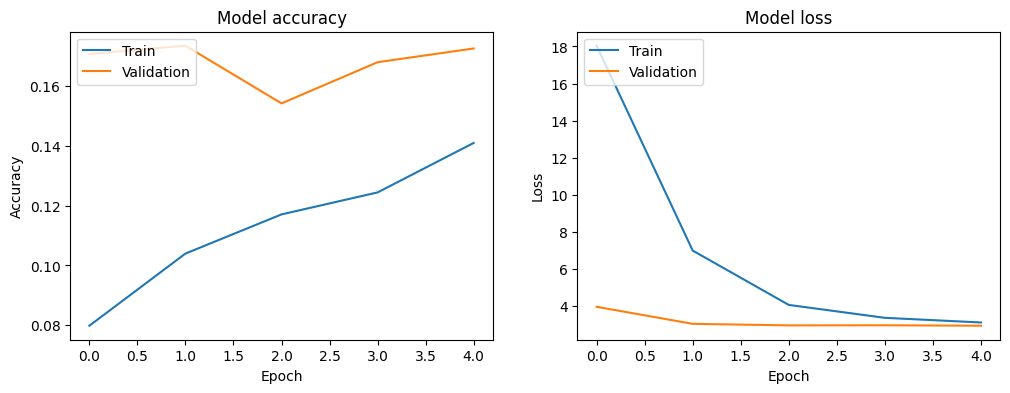

In [33]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [34]:
# The accuracy of the model and model loss show that the model is neither overfit nor underfit, but the accuracy of the model is low,
# which we can improve by increasing the number of epochs, but due to the limitation of time to send homework, it is not possible to do this.